In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as dsets
from torch.utils.data import Dataset,DataLoader
from torchvision import models

import cv2

import matplotlib.pyplot as plt

import os
os.chdir("/projects/2019연구학점제/")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import time
import copy
import random as rd

device = torch.device('cuda')

In [10]:
batch_size_train = 256
batch_size_test = 256

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('..data/MNIST/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/MNIST/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_test, shuffle=True)

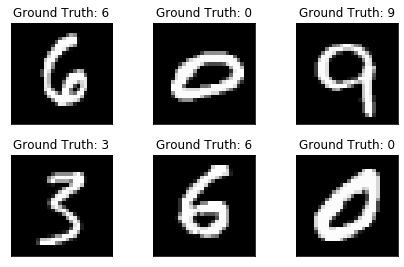

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [12]:
class flatten(nn.Module):
    def __init__(self):
        super(flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

class sampler_net(nn.Module):
    def __init__(self, num_params):
        super(sampler_net, self).__init__()
        self.kernel_size = (3, 3)
        self.num_params = num_params
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 4, kernel_size = self.kernel_size, padding = tuple(x//2 for x in self.kernel_size), stride = (2, 2)),
            nn.MaxPool2d((2,2)),
            
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size = self.kernel_size, padding = tuple(x//2 for x in self.kernel_size), stride = (2, 2)),
            nn.MaxPool2d((2,2)),

            flatten()
        )
        
        self.mean = nn.Sequential(
            
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, self.num_params),
        )
        
        self.var = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, self.num_params),
            
            nn.Softplus()
        )

        self.sample_dist = torch.distributions.MultivariateNormal(torch.zeros(self.num_params), torch.eye(self.num_params))
    
    def forward(self, x):
        x = self.encoder(x)
        return self.mean(x) + (self.sample_dist.sample().cuda() * self.var(x))

    
class sample_net(nn.Module):
    def __init__(self):
        super(sample_net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = (3, 3), padding = (1, 1), stride = (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            
            nn.Conv2d(4, 8, kernel_size = (3, 3), padding = (1, 1), stride = (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            
            flatten(),
            
            nn.Linear(2 * 2 * 8, 10, bias = True),
        )
        
    def forward(self, x):
        return self.layers(x).unsqueeze(0)
    
    def set_params(self, params):
        param_count = 0
        self.layers[0].weight = torch.nn.Parameter(params[param_count:param_count + self.layers[0].weight.numel()].view(self.layers[0].weight.size()))
        param_count += self.layers[0].weight.numel()
        self.layers[0].bias = torch.nn.Parameter(params[param_count:param_count + self.layers[0].bias.numel()].view(self.layers[0].bias.size()))
        param_count += self.layers[0].bias.numel()
        self.layers[3].weight = torch.nn.Parameter(params[param_count:param_count + self.layers[3].weight.numel()].view(self.layers[3].weight.size()))
        param_count += self.layers[3].weight.numel()
        self.layers[3].bias = torch.nn.Parameter(params[param_count:param_count + self.layers[3].bias.numel()].view(self.layers[3].bias.size()))
        param_count += self.layers[3].bias.numel()
        self.layers[7].weight = torch.nn.Parameter(params[param_count:param_count + self.layers[7].weight.numel()].view(self.layers[7].weight.size()))
        param_count += self.layers[7].weight.numel()
        self.layers[7].bias = torch.nn.Parameter(params[param_count:param_count + self.layers[7].bias.numel()].view(self.layers[7].bias.size()))
        param_count += self.layers[7].bias.numel()
    
    def fit(self, x, params):
        for ind in range(params.shape[0]):
            self.set_params(params[ind])
            if ind:
                output= torch.cat((output, self.forward(x)))
            else:
                output = self.forward(x)
        return output

In [13]:
%%time
sample = sample_net().cuda()
print([p.numel() for p in sample.parameters() if p.requires_grad])
print(sum(p.numel() for p in sample.parameters() if p.requires_grad))

sampler = sampler_net(sum(p.numel() for p in sample.parameters() if p.requires_grad)).cuda()
print([p.numel() for p in sampler.parameters() if p.requires_grad])
print(sum(p.numel() for p in sampler.parameters() if p.requires_grad))

[36, 4, 288, 8, 320, 10]
666
[1, 1, 36, 4, 4, 4, 288, 8, 32, 32, 21312, 666, 32, 32, 21312, 666]
44430
CPU times: user 143 ms, sys: 40.3 ms, total: 183 ms
Wall time: 360 ms


In [14]:
%%time
print(sampler(example_data.cuda()).shape)
print(sample.fit(example_data.cuda(), sampler(example_data.cuda())).shape)

torch.Size([256, 666])
torch.Size([256, 256, 10])
CPU times: user 457 ms, sys: 0 ns, total: 457 ms
Wall time: 602 ms


<h1>Training</h1>

In [7]:
epoch = 1000
lr = 3e-4
optimizer_sample = torch.optim.Adam(sample.parameters(), lr = lr)
optimizer_sampler = torch.optim.Adam(sampler.parameters(), lr = lr)

In [8]:
sample = sample_net().cuda()
sampler = sampler_net(sum(p.numel() for p in sample.parameters() if p.requires_grad)).cuda()

In [10]:
CE_loss = nn.CrossEntropyLoss()
def multi_crit(output, label):
    loss = 0.0
    for dim in range(output.shape[0]):
        loss += CE_loss(output[dim], label)
    return loss
criterion = multi_crit

In [11]:
for run in range(epoch):
    start = time.time()
    
    #Training
    sampler.train()
    sample.train()
    for ind, data in enumerate(train_loader):
        optimizer_sampler.zero_grad()
        img, label = data
        output = sample.fit(img.cuda(), sampler(img.cuda()))
        loss = multi_crit(output, label.cuda())
        loss.backward()
        optimizer_sampler.step()
    
    #Test
    sampler.eval()
    sample.eval()
    with torch.no_grad():
        test_loss = 0.0
        for ind, data in enumerate(test_loader):
            img, label = data
            output = sample.fit(img.cuda(), sampler(img.cuda()))
            test_loss += multi_crit(output, label.cuda())
        test_loss /= (len(test_loader) * 64)
    print("epoch : %d, test loss = %5.5f, time: %f sec" %(run, test_loss, time.time() - start))

epoch : 0, test loss = 299.38000, time: 123.176095 sec
epoch : 1, test loss = 318.00900, time: 123.208699 sec
epoch : 2, test loss = 302.55817, time: 123.238706 sec
epoch : 3, test loss = 295.77338, time: 123.376549 sec
epoch : 4, test loss = 308.97491, time: 123.362425 sec
epoch : 5, test loss = 339.54861, time: 123.338022 sec
epoch : 6, test loss = 308.51120, time: 123.297865 sec
epoch : 7, test loss = 270.11276, time: 123.262603 sec


KeyboardInterrupt: 